/home/mmc/anaconda3/envs/CPR_YOLO/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mmc/anaconda3/envs/CPR_YOLO/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[562 764 558 557 903  33 779  29 527 729]
[-67.77615  -72.01244  -72.64336  -73.25322  -74.60912  -75.46274
 -76.0849   -76.612114 -76.99055  -77.16772 ]
Test Predictions: 삼양패키징)버터모카
Identified Classes in Segmentation Mask:
Class 0: background
Class 1: drink
Class 3: Human_hand


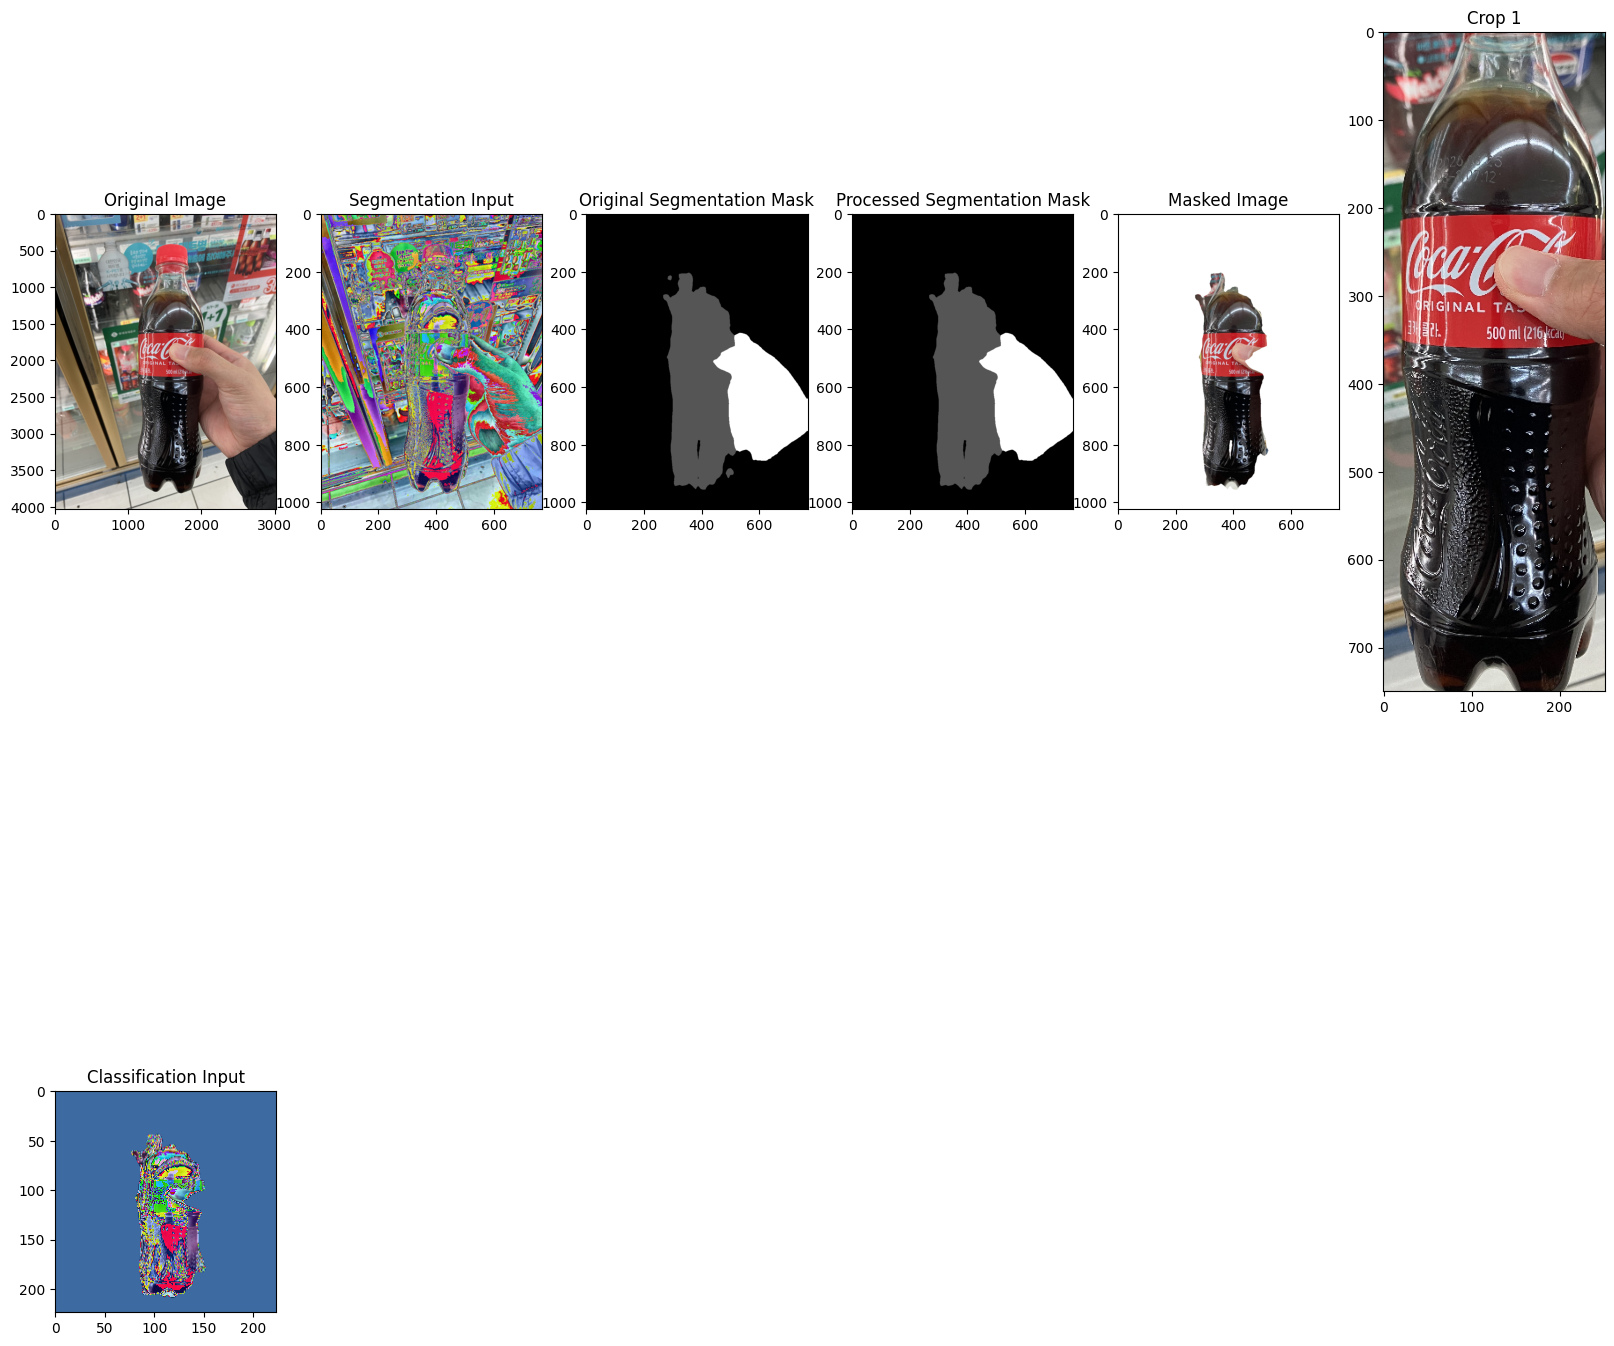

In [26]:
import torch
import torchvision
from torchvision import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timm
from scipy.ndimage import label
import copy

# 이미지 로드 및 전처리
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((1024, 768)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = preprocess(img)
    img_resized = cv2.resize(img, (768, 1024))
    img_tensor = img_tensor.unsqueeze(0)  # 배치 차원 추가
    return img, img_tensor, img_resized

# 추론 함수
def predict(model, image_tensor, device):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = model(image_tensor)['out'][0]
    output_predictions = output.argmax(0)
    return output_predictions.byte().cpu().numpy()

# 더 큰 클래스만 남기고 나머지를 배경으로 전환
def select_largest_class(mask, class1_id, class2_id):
    class1_size = np.sum(mask == class1_id)
    class2_size = np.sum(mask == class2_id)
    if class1_size > class2_size:
        mask[mask == class2_id] = 0  # 작은 클래스는 배경으로 설정
        return class1_id
    else:
        mask[mask == class1_id] = 0  # 작은 클래스는 배경으로 설정
        return class2_id

# 같은 클래스 중 가장 큰 바운딩 박스만 남기기
def select_largest_bbox(mask, class_id):
    labeled_mask, num_labels = label(mask == class_id)
    largest_area = 0
    largest_label = 0
    for i in range(1, num_labels + 1):
        area = np.sum(labeled_mask == i)
        if area > largest_area:
            largest_area = area
            largest_label = i
    mask[mask == class_id] = 0  # 모든 객체를 배경으로 설정
    mask[labeled_mask == largest_label] = class_id  # 가장 큰 바운딩 박스만 남기기
    return mask

# 결과 시각화
def visualize_results(original_img, img_tensor, original_mask, mask, masked_img, classification_img, individual_crops):
    num_crops = len(individual_crops)
    plt.figure(figsize=(20, 20))
    plt.subplot(2, num_crops + 5, 1)
    plt.title("Original Image")
    plt.imshow(original_img)
    plt.subplot(2, num_crops + 5, 2)
    plt.title("Segmentation Input")
    plt.imshow(transforms.ToPILImage()(img_tensor.squeeze(0)))
    plt.subplot(2, num_crops + 5, 3)
    plt.title("Original Segmentation Mask")
    plt.imshow(original_mask, cmap='gray')
    plt.subplot(2, num_crops + 5, 4)
    plt.title("Processed Segmentation Mask")
    plt.imshow(mask, cmap='gray')
    if masked_img is not None:
        plt.subplot(2, num_crops + 5, 5)
        plt.title("Masked Image")
        plt.imshow(masked_img)
        plt.imsave('masked.png',masked_img)
    for i, crop in enumerate(individual_crops):
        plt.subplot(2, num_crops + 5, 6 + i)
        plt.title(f"Crop {i + 1}")
        plt.imshow(crop)
    if classification_img is not None:
        plt.subplot(2, num_crops + 5, num_crops + 6)
        plt.title("Classification Input")
        plt.imshow(transforms.ToPILImage()(classification_img))
    plt.show()

# 마스크를 사용하여 이미지를 크롭하고 배경을 흰색으로 설정
def apply_mask(img, mask):
    masked_img = np.where((mask[..., None] == 0) | (mask[..., None] == 3), 255, img)
    return masked_img

# 작은 객체를 제거하고 각각 크롭
def crop_individual_objects(masked_img, mask, class_id, min_size=(50, 50)):
    labeled_mask, num_labels = label(mask == class_id)
    crops = []
    for i in range(1, num_labels + 1):
        y, x = np.where(labeled_mask == i)
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()
        if (x_max - x_min) >= min_size[0] and (y_max - y_min) >= min_size[1]:  # 최소 크기 필터링
            crop = masked_img[y_min:y_max, x_min:x_max]
            crops.append(crop)
        else:
            # 작은 객체를 백그라운드로 채우기
            mask[y_min:y_max, x_min:x_max] = 0
    masked_img = apply_mask(masked_img, mask)  # 작은 객체 제거 후 다시 마스크 처리
    return masked_img, crops

# 제품 이름 가져오기
def get_product_name(class_id, csv_path):
    df = pd.read_csv(csv_path)
    class_to_name = df.set_index('class')['img_prod_nm'].to_dict()
    return class_to_name.get(class_id, "Unknown Product")

# 모델 로드 함수
def load_model(model_path, model, device='cuda'):
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

# 추론 함수
def inference(model, image, device='cuda'):
    model.eval()
    with torch.no_grad():
        image = image.to(device).unsqueeze(0)  # 배치를 추가하기 위해 unsqueeze(0)을 사용
        outputs = model(image)
        logits = outputs.cpu().numpy()
        top10_indices = np.argsort(logits[0])[::-1][:10]
        print(top10_indices)
        print(logits[0][top10_indices])
        _, preds = torch.max(outputs, 1)
    return preds.cpu().numpy()

# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CUSTOM_CLASSES = ['background', 'drink', 'snack', 'Human_hand']

def main(image_path, model_path, output_path, csv_path, best_model_path, num_classes):
    # 분할 모델 준비
    model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
    # model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)

    model.classifier[4] = torch.nn.Conv2d(256, len(CUSTOM_CLASSES), kernel_size=1)
    # model.classifier[4] = torch.nn.Conv2d(512, len(CUSTOM_CLASSES), kernel_size=1)

    model = load_model('/home/mmc/disk2/duck/cap/DeepLabV3+/pt/best_dl50.pt', model, device)
    # model = load_model(model_path, model, device)


    # 이미지 로드 및 전처리
    original_img, img_tensor, img_resized = load_image(image_path)

    # 분할 수행
    original_mask = predict(model, img_tensor, device)
    original_mask_copy = copy.deepcopy(original_mask)

    # snack과 drink 클래스 중 더 큰 것을 남기고 나머지는 배경으로 전환
    remaining_class_id = select_largest_class(original_mask, class1_id=2, class2_id=1)

    # hand 클래스가 식별된 경우에만 가장 큰 바운딩 박스만 남기기
    if np.any(original_mask == 3):
        mask = select_largest_bbox(original_mask, class_id=remaining_class_id)

    # hand 클래스 식별 안됐을 시 코너 출력 후 종료
    else:
        visualize_results(original_img, img_tensor, original_mask_copy, original_mask, None, None, [])
        print(f'{CUSTOM_CLASSES[remaining_class_id]} corner')
        return

    # 작은 객체를 제거하고 각각 크롭
    masked_img, individual_crops = crop_individual_objects(img_resized, mask, class_id=remaining_class_id, min_size=(50, 50))

    masked_img = apply_mask(img_resized, mask)

    # 분할된 이미지 변환
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    classification_img = transform(masked_img)

    # remaining_class_id에 따라 분류 모델 경로 및 csv 파일 경로 변경
    if remaining_class_id == 2:
        classification_model_path = 'snack.pt'
        csv_path = 'snack.csv'
        num_classes = 1637
    else:
        classification_model_path = 'drink.pt'
        # classification_model_path = 'duck/cap/cnn/drink_pt_0519_resnet18/best.pt'
        
        csv_path = 'drink.csv'
        num_classes = 1044

    # 분류 모델 준비
    classification_model = timm.create_model('resnet18', pretrained=True, num_classes=num_classes)
    classification_model = load_model(classification_model_path, classification_model, device)

    # 추론 수행
    test_predictions = inference(classification_model, classification_img, device)
    result = get_product_name(test_predictions[0], csv_path)

    print(f'Test Predictions: {result}')

    # 식별된 클래스 출력
    print("Identified Classes in Segmentation Mask:")
    for cls in np.unique(original_mask):
        print(f"Class {cls}: {CUSTOM_CLASSES[cls]}")

    # 결과 시각화
    visualize_results(original_img, img_tensor, original_mask_copy, mask, masked_img, classification_img, individual_crops)

if __name__ == "__main__":
    image_path = '/home/mmc/disk2/duck/cap/data/drink/test/코카콜라.jpg'
    model_path = '/home/mmc/disk2/duck/cap/DeepLabV3+/pt/best_fcn50.pt'
    output_path = 'masked_image.png'
    csv_path = './drink.csv'  # 초기값, 필요에 따라 변경됨
    best_model_path = './drink.pt'  # 초기값, 필요에 따라 변경됨
    num_classes = 1044  # 초기값, 필요에 따라 변경됨 drink 1044, noodle 205, snack 1637

    main(image_path, model_path, output_path, csv_path, best_model_path, num_classes)
